In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math
import cftime
import cartopy.crs as ccrs

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [60]:
import palettable

ModuleNotFoundError: No module named 'palettable'

In [2]:
def weighted_mean(data_da, dim, weights):
    r"""Computes the weighted mean.

    We can only do the actual weighted mean over the dimensions that
    ``data_da`` and ``weights`` share, so for dimensions in ``dim`` that aren't
    included in ``weights`` we must take the unweighted mean.

    This functions skips NaNs, i.e. Data points that are NaN have corresponding
    NaN weights.

    Args:
        data_da (xarray.DataArray):
            Data to compute a weighted mean for.
        dim (str | list[str]):
            dimension(s) of the dataarray to reduce over
        weights (xarray.DataArray):
            a 1-D dataarray the same length as the weighted dim, with dimension
            name equal to that of the weighted dim. Must be nonnegative.
    Returns:
        (xarray.DataArray):
            The mean over the given dimension. So it will contain all
            dimensions of the input that are not in ``dim``.
    Raises:
        (IndexError):
            If ``weights.dims`` is not a subset of ``dim``.
        (ValueError):
            If ``weights`` has values that are negative or infinite.
    """
    if isinstance(dim, str):
        dim = [dim]
    else:
        dim = list(dim)

    if not set(weights.dims) <= set(dim):
        dim_err_msg = (
            "`weights.dims` must be a subset of `dim`. {} are dimensions in "
            "`weights`, but not in `dim`."
        ).format(set(weights.dims) - set(dim))
        raise IndexError(dim_err_msg)
    else:
        pass  # `weights.dims` is a subset of `dim`

    if (weights < 0).any() or xr.ufuncs.isinf(weights).any():
        negative_weight_err_msg = "Weight must be nonnegative and finite"
        raise ValueError(negative_weight_err_msg)
    else:
        pass  # `weights` are nonnegative

    weight_dims = [
        weight_dim for weight_dim in dim if weight_dim in weights.dims
    ]

    if np.isnan(data_da).any():
        expanded_weights, _ = xr.broadcast(weights, data_da)
        weights_with_nans = expanded_weights.where(~np.isnan(data_da))
    else:
        weights_with_nans = weights

    mean_da = ((data_da * weights_with_nans).sum(weight_dims, skipna=True)
               / weights_with_nans.sum(weight_dims))
    other_dims = list(set(dim) - set(weight_dims))
    return mean_da.mean(other_dims, skipna=True)

In [3]:
fname = '/projects/b1045/cmip/CMIP5/NCL_Practice/tas_Amon_CESM1-WACCM_rcp85_r2i1p1_200601-209912.nc'

In [4]:
DS=xr.open_dataset(fname)

In [5]:
data_2006_2099=DS.sel(time=slice('2006-01-01','2099-12-31'))
data_2006_2099_tas_mean=data_2006_2099.tas.mean(dim='time')

In [6]:
lat = data_2006_2099_tas_mean.lat # latitude
lon = data_2006_2099_tas_mean.lon # longitude

In [15]:
#Projection for plot
projection= ccrs.Mollweide(central_longitude=255);
# Data projection  -- these are different!
data_crs = ccrs.PlateCarree()

Text(0.5, 1.0, 'Temperature')

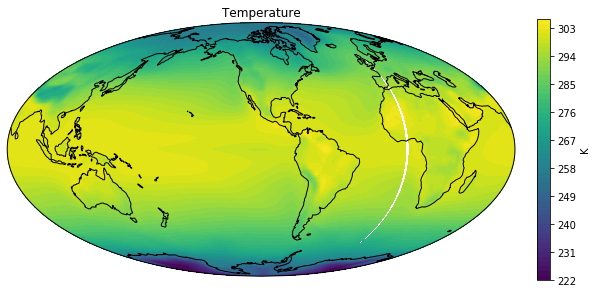

In [23]:
# Open figure object
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=projection)
ax.set_global()
ax.coastlines()

cf=ax.contourf(lon, lat, data_2006_2099_tas_mean, levels=60, transform=data_crs, cbar_kwargs={'label': DS.tas.units})
cb = plt.colorbar(cf, fraction=0.05, pad=0.04, shrink=0.8)
cb.set_label(DS.tas.units)

plt.title("Temperature")

In [24]:
rad  = 4.*math.atan(1.)/180.
weights   = np.cos(lat*rad)

In [25]:
wmean_lat = weighted_mean(data_2006_2099.tas, dim='lat', weights=weights)
wmean = wmean_lat.mean(dim='lon')
annual_wmean = wmean.groupby('time.year').mean(dim='time')

Text(0.0, 1.0, 'Global Annual Mean Temperatures')

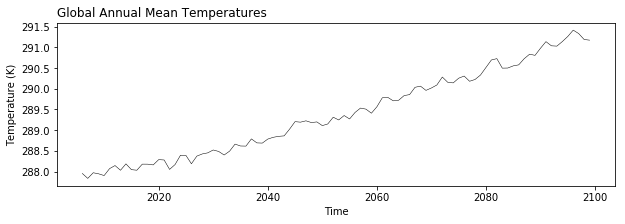

In [28]:
plt.figure(figsize=(10,3))
plt.plot(annual_wmean.year, annual_wmean.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Annual Mean Temperatures', loc='left')

In [29]:
baseline = wmean.sel(time=slice('2006-01-01','2035-12-31')).mean(dim='time')

In [30]:
anomaly = annual_wmean - baseline

Text(0.0, 1.0, 'Global Annual Temperature Anomaly')

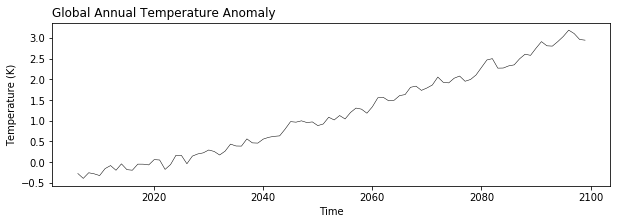

In [31]:
plt.figure(figsize=(10,3))
plt.plot(anomaly.year, anomaly.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Annual Temperature Anomaly', loc='left')

In [32]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [33]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [35]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(data_2006_2099.time.to_index(), calendar='noleap'),
                            coords=[data_2006_2099.time], name='month_length')



In [37]:
# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.season') / month_length.astype(float).groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
#np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (data_2006_2099.tas * weights).groupby('time.season').sum(dim='time')

In [38]:
ds_weighted

<xarray.DataArray (season: 4, lat: 96, lon: 144)>
array([[[244.878724, 244.907538, ..., 244.99549 , 244.896846],
        [246.171962, 245.89811 , ..., 246.433516, 246.363594],
        ...,
        [244.680724, 244.737817, ..., 244.556906, 244.619385],
        [243.600787, 243.605937, ..., 243.571612, 243.589451]],

       [[222.302285, 222.296427, ..., 222.303672, 222.298238],
        [223.734557, 223.619704, ..., 224.060138, 223.866605],
        ...,
        [271.887055, 271.893906, ..., 271.875177, 271.881134],
        [271.892378, 271.894585, ..., 271.888651, 271.890307]],

       [[226.172087, 226.163088, ..., 226.181341, 226.165574],
        [227.083769, 226.989782, ..., 227.3936  , 227.200913],
        ...,
        [252.777725, 252.804328, ..., 252.715356, 252.748135],
        [252.246934, 252.253276, ..., 252.226182, 252.237641]],

       [[227.819565, 227.823162, ..., 227.840614, 227.820587],
        [229.153066, 228.958143, ..., 229.478169, 229.332874],
        ...,
        [2

In [58]:
data_DJF = ds_weighted.sel(season='DJF')
data_MAM = ds_weighted.sel(season='MAM')
data_JJA = ds_weighted.sel(season='JJA')
data_SON = ds_weighted.sel(season='SON')

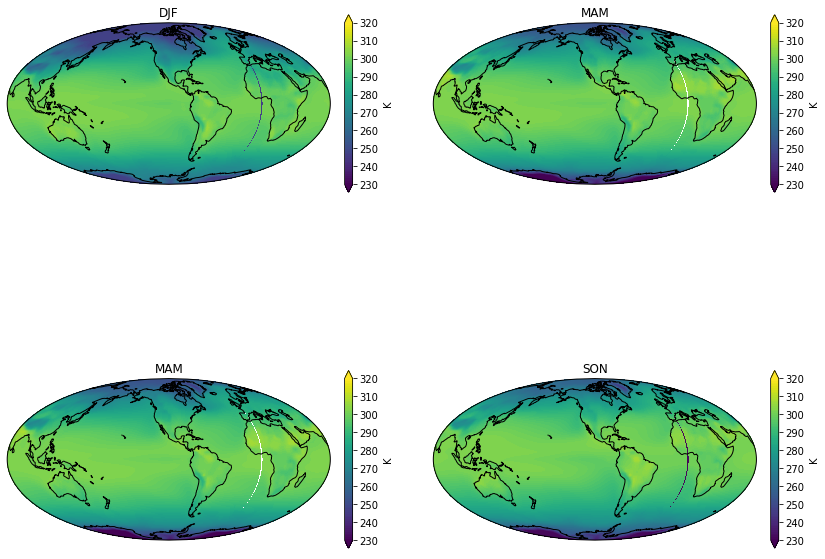

In [80]:
# Open figure object
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,12),subplot_kw={'projection': ccrs.Mollweide(central_longitude=255)})

# add coastlines for all axes
for ax in [ax1,ax2,ax3,ax4]:
    ax.coastlines()

ax1.set_title('DJF')
cf1=ax1.contourf(lon, lat, data_DJF, levels=np.linspace(230, 320, 91), 
                 extend='both', transform=data_crs, 
                 cbar_kwargs={'label': DS.tas.units})
cb1 = plt.colorbar(cf1, fraction=0.05, pad=0.04, shrink=0.6, ax=ax1)
cb1.set_label(DS.tas.units)

ax2.set_title('MAM')
cf2=ax2.contourf(lon, lat, data_MAM, levels=np.linspace(230, 320, 91), 
                 extend='both', transform=data_crs, 
                 cbar_kwargs={'label': DS.tas.units})
cb2 = plt.colorbar(cf2, fraction=0.05, pad=0.04, shrink=0.6, ax=ax2)
cb2.set_label(DS.tas.units)

ax3.set_title('MAM')
cf3=ax3.contourf(lon, lat, data_MAM, levels=np.linspace(230, 320, 91), 
                 extend='both', transform=data_crs, 
                 cbar_kwargs={'label': DS.tas.units})
cb3 = plt.colorbar(cf3, fraction=0.05, pad=0.04, shrink=0.6, ax=ax3)
cb3.set_label(DS.tas.units)

ax4.set_title('SON')
cf4=ax4.contourf(lon, lat, data_SON, levels=np.linspace(230, 320, 91), 
                 extend='both', transform=data_crs, 
                 cbar_kwargs={'label': DS.tas.units})
cb4 = plt.colorbar(cf4, fraction=0.05, pad=0.04, shrink=0.6, ax=ax4)
cb4.set_label(DS.tas.units)

